In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import scipy.misc
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras.constraints import max_norm, unit_norm, min_max_norm
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/My Drive/Datasets/UCMerced_LandUse/Train_UCMerced_LandUse.h5', 'r')
    train_set_x_orig = np.array(train_dataset["X_train_dataset"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["Y_train_dataset"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/My Drive/Datasets/UCMerced_LandUse/Test_UCMerced_LandUse.h5', 'r')
    test_set_x_orig = np.array(test_dataset["X_test_dataset"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["Y_test_dataset"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the data (Dataset)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 4


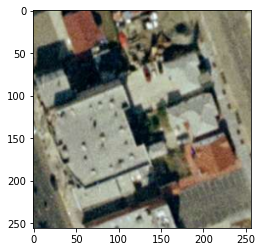

In [ ]:
#for i in range(X_train_orig.shape[0]):
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='HSV')
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='YCbCr')

#for j in range(X_test_orig.shape[0]):
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='HSV')
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='YCbCr')

index = 25
plt.imshow(Image.fromarray(X_train_orig[index].astype(np.uint8)))
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 21)
Y_test = convert_to_one_hot(Y_test_orig, 21)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1680
number of test examples = 420
X_train shape: (1680, 256, 256, 3)
Y_train shape: (1680, 21)
X_test shape: (420, 256, 256, 3)
Y_test shape: (420, 21)


In [ ]:
VGG_Out = h5py.File('/content/drive/My Drive/Datasets/UCMerced_LandUse/Convout/TLConvFnl/VGG_Out.h5', 'r')
Txtrain = np.array(VGG_Out["train_Outvgg"][:])
Txtest = np.array(VGG_Out["test_Outvgg"][:])
VGG_Out.close()

print("Txtrain shape:", Txtrain.shape)
print("Txtest shape:", Txtest.shape)

Txtrain shape: (1680, 7, 7, 512)
Txtest shape: (420, 7, 7, 512)


In [ ]:
#np.random.seed(8)
#model.add(layers.Dropout(0.5))
#layers.ActivityRegularization(l1=0.1, l2=0.1),   kernel_regularizer=regularizers.l2(0.001)

model = models.Sequential()
model.add(layers.Input(shape = (7, 7, 512)))
model.add(layers.Flatten())
model.add(layers.ReLU())
model.add(layers.Dropout(0.77))
model.add(layers.Dense(21, activation='softmax'))
print(model.summary())
optimizers.Adam(learning_rate=0.001,name="Adam")
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Vhistory = model.fit(Txtrain, Y_train, epochs=100, verbose=1, batch_size=64, validation_split = 0.25)

train_loss, train_acc = model.evaluate(Txtrain,  Y_train, verbose=1)
print("Loss: ", train_loss, " Train Accuracy: ", train_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
re_lu (ReLU)                 (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 21)                526869    
Total params: 526,869
Trainable params: 526,869
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
20/20 [==============================] - 1s 36ms/step - loss: 15.3300 - accuracy: 0.4317 - val_loss: 3.0849 - val_accuracy: 0.7429
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 2.2048 - accuracy: 0.8690 

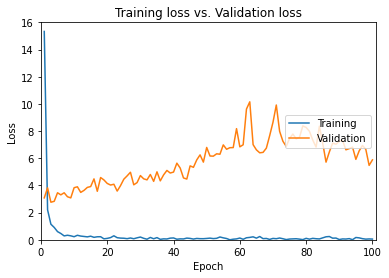

In [ ]:
epochs = len(Vhistory.history['loss'])
max_loss = max(max(Vhistory.history['loss']), max(Vhistory.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['loss'])
plt.plot(x, Vhistory.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

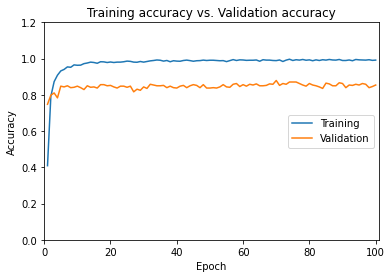

In [ ]:
epochs = len(Vhistory.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['accuracy'])
plt.plot(x, Vhistory.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [ ]:
#np.random.seed(8)

epochs = np.argmin(Vhistory.history['val_loss']) + 1

history = model.fit(Txtrain, Y_train, epochs=epochs, verbose=1, batch_size=64, validation_split=0)

train_loss, train_acc = model.evaluate(Txtrain,  Y_train, verbose=1)
print("Loss: ", train_loss, " Train Accuracy: ", train_acc)

test_loss, test_acc = model.evaluate(Txtest,  Y_test, verbose=1)
print("Loss: ", test_loss, " Test Accuracy: ", test_acc)

Epoch 1/5
30/30 [==============================] - 1s 25ms/step - loss: 0.2731 - accuracy: 0.9917
Epoch 2/5
30/30 [==============================] - 1s 26ms/step - loss: 0.1618 - accuracy: 0.9922
Epoch 3/5
30/30 [==============================] - 1s 25ms/step - loss: 0.1656 - accuracy: 0.9953
Epoch 4/5
30/30 [==============================] - 1s 25ms/step - loss: 0.2275 - accuracy: 0.9948
Epoch 5/5
60/60 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Loss:  0.0  Train Accuracy:  1.0
15/15 [==============================] - 0s 4ms/step - loss: 6.2021 - accuracy: 0.9292
Loss:  6.2021379470825195  Test Accuracy:  0.9291666746139526


In [ ]:
import pandas as pd

array1 = np.zeros((100,2))
array1[:,0] = Vhistory.history['loss']
array1[:,1] = Vhistory.history['val_loss']

array2 = np.zeros((100,2))
array2[:,0] = Vhistory.history['accuracy']
array2[:,1] = Vhistory.history['val_accuracy']

df1 = pd.DataFrame(array1)
df1.to_excel("/content/drive/My Drive/VGGML.xlsx", sheet_name='Merced Loss')

df2 = pd.DataFrame(array2)
df2.to_excel("/content/drive/My Drive/VGGMA.xlsx", sheet_name='Merced accuracy')